### <center> Quiz 1 </center>

#### Integrantes:
- Tomás Lopera
- Pedro Sierra

### 1. Librerías necesarias

In [186]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import rv_discrete, rv_histogram, binom, mode, triang, kstest
from statsmodels.distributions.empirical_distribution import ECDF

### 2. Entradas conocidas

In [229]:
ingresos_primera_clase = {"Boston_Atlanta": 400, "Atlanta_Chicago": 400, "Chicago_Boston": 450}
ingresos_clase_turista = {"Boston_Atlanta": 175, "Atlanta_Chicago": 150, "Chicago_Boston": 200}

demanda_boston_atlanta = [160, 180, 220]
demanda_chicago_boston = [150, 200, 225]

datos_historicos_atlanta_chicago = [
    173, 212, 225, 199, 205, 176, 215, 198, 198, 184,
    199, 211, 233, 195, 217, 209, 177, 161, 175, 209,
    197, 206, 167, 196, 205, 219, 184, 172, 207, 191,
    164, 216, 163, 236, 183, 213, 195, 182, 238, 141,
    178, 211, 165, 213, 186, 202, 186, 194, 210, 206,
    196, 197, 236, 173, 199, 211, 168, 181, 206, 216,
    196, 201, 180, 209, 176, 221, 190, 206, 190, 210
]
demanda_atlanta_chicago = [140, mode(datos_historicos_atlanta_chicago, keepdims=True).mode[0], 240]

frac_ventas_primera_clase = [0.05, 0.12, 0.15]
prob_primera_clase = [0.2, 0.5, 0.3]

costo_fijo = 100000

# Configuración sugerida para analizar: 3 filas de primera clase, 34 de turista
filas_primera = 3  # 4 asientos por fila
filas_turista = 34  # 6 asientos por fila

### 3. Variables de decisión

In [230]:
capacidad_primera = filas_primera * 4  # 3 filas x 4 asientos
capacidad_turista = filas_turista * 6  # 34 filas x 6 asientos

### 4. Entradas inciertas

In [231]:
tramos = {
    "Boston_Atlanta": demanda_boston_atlanta,
    "Chicago_Boston": demanda_chicago_boston,
    "Atlanta_Chicago": demanda_atlanta_chicago
}

demandas_dist = {
    tramo: triang(
        c=(datos[1] - datos[0]) / (datos[2] - datos[0]),
        loc=datos[0],
        scale=(datos[2] - datos[0])
    ) 
    for tramo, datos in tramos.items()
}

frac_primera_clase_dist = rv_discrete(values=(frac_ventas_primera_clase, prob_primera_clase))
    

### 5. Cálculos intermedios

In [242]:
def simulacion():
        beneficio_fijo = []

        for _ in range(20000):
                demanda_simulada = {tramo: dist.rvs() for tramo, dist in demandas_dist.items()}
                fraccion_primera = frac_primera_clase_dist.rvs()
                
                ingresos = 0

                # Calcular ingresos por tramo
                for tramo, demanda in demanda_simulada.items():
                        primera_clase = min(binom.rvs(n=int(demanda), p=fraccion_primera), capacidad_primera)
                        clase_turista = min(capacidad_turista, demanda * (1 - fraccion_primera))
                        ingresos += (primera_clase * ingresos_primera_clase[tramo]) + (clase_turista * ingresos_clase_turista[tramo])

                beneficio_fijo.append(ingresos - costo_fijo)

        return beneficio_fijo

sim = simulacion()
df_beneficios = pd.DataFrame(sim, columns=["Beneficio"])

 Beneficio esperado por día con la configuración fija: $3010.93
 Proporción de días en equilibrio: 72.41%


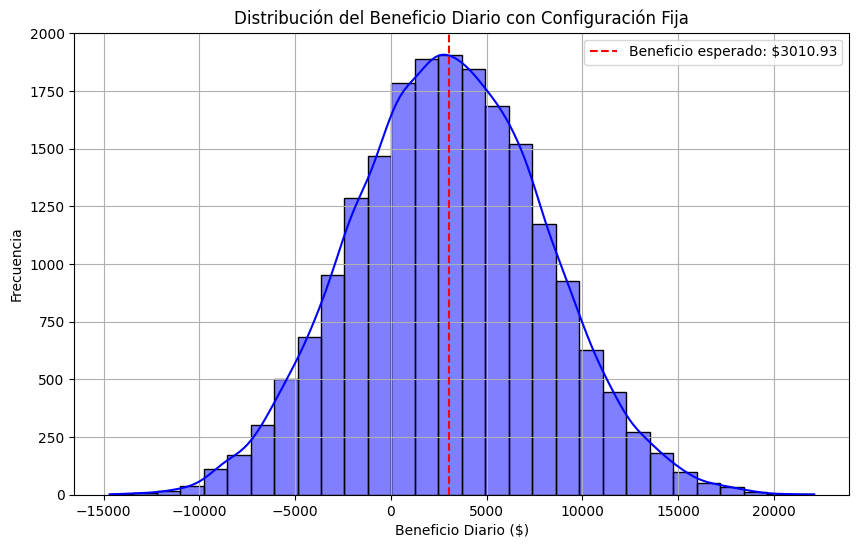

In [243]:
# Estadísticas de la simulación
beneficio_esperado = df_beneficios["Beneficio"].mean()
print(f" Beneficio esperado por día con la configuración fija: ${beneficio_esperado:.2f}")

dias_equilibrio = (df_beneficios["Beneficio"] >= 0).mean()
print(f" Proporción de días en equilibrio: {dias_equilibrio * 100:.2f}%")

# Gráfica de la distribución del beneficio diario
plt.figure(figsize=(10, 6))
sns.histplot(df_beneficios["Beneficio"], kde=True, bins=30, color="blue")
plt.axvline(beneficio_esperado, color="red", linestyle="--", label=f"Beneficio esperado: ${beneficio_esperado:.2f}")
plt.xlabel("Beneficio Diario ($)")
plt.ylabel("Frecuencia")
plt.title("Distribución del Beneficio Diario con Configuración Fija")
plt.legend()
plt.grid()
plt.show()

In [244]:
resultados =[]
posibilidades = range(0,21)

for filas_primera in posibilidades:
    filas_turista = 40 - filas_primera * 2 
    
    capacidad_primera = filas_primera * 4 
    capacidad_turista = filas_turista * 6
    beneficio_simulado = simulacion()
  
    resultados.append({
    "filas_primera": filas_primera,
    "filas_turista": filas_turista,
    "beneficio_medio": np.mean(beneficio_simulado),
    "percentil_20": np.percentile(beneficio_simulado, 20),
    "percentil_80": np.percentile(beneficio_simulado, 80),
    "max_beneficio": np.max(beneficio_simulado),
    "min_beneficio": np.min(beneficio_simulado)
    })

df_resultados = pd.DataFrame(resultados)
 

 Mejor configuración de asientos:
   - Filas de primera clase: 6.0
   - Filas de turista: 28.0
   - Beneficio esperado: $9665.16


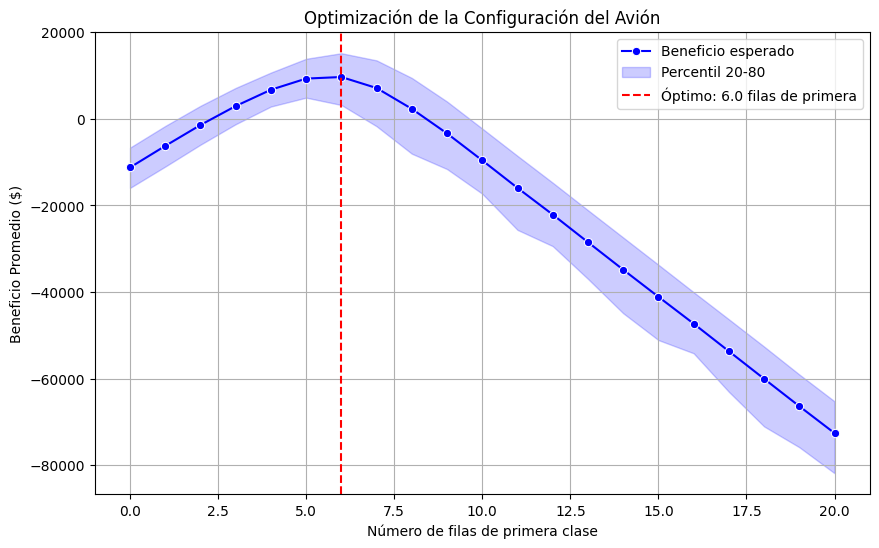

In [245]:
mejor_configuracion = df_resultados.loc[df_resultados["beneficio_medio"].idxmax()]

# Resultados de la optimización
print(f" Mejor configuración de asientos:")
print(f"   - Filas de primera clase: {mejor_configuracion['filas_primera']}")
print(f"   - Filas de turista: {mejor_configuracion['filas_turista']}")
print(f"   - Beneficio esperado: ${mejor_configuracion['beneficio_medio']:.2f}")

# Gráfica de la optimización de la configuración del avión
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_resultados, x="filas_primera", y="beneficio_medio", marker="o", color="b", label="Beneficio esperado")
plt.fill_between(df_resultados["filas_primera"], df_resultados["percentil_20"], df_resultados["percentil_80"], alpha=0.2, color="b", label="Percentil 20-80")
plt.axvline(mejor_configuracion["filas_primera"], color='r', linestyle='--', label=f"Óptimo: {mejor_configuracion['filas_primera']} filas de primera")
plt.xlabel("Número de filas de primera clase")
plt.ylabel("Beneficio Promedio ($)")
plt.title("Optimización de la Configuración del Avión")
plt.legend()
plt.grid()
plt.show()